# Notebook for comparing observing stratergies and their effect on Supernova classification

This notebook illustrates the use of the `snmachine` supernova classification package for comparing cadence runs for the LSST.

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. 

For this analysis we have chosen to use wavelets for feature extraction and then to use random forests algorithm to complete the classification.

In [23]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot, example_data
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits,ascii
import sklearn.metrics 
import sncosmo
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

In [24]:
dataset='lsst_wfd'

In [25]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_%s_no_z' %dataset,'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

In [26]:
print(outdir)

output_lsst_wfd_no_z/


## Initialise dataset object

Load cadence simulation data

In [27]:
!pwd

/Users/tallamjr/PhD/project/snmachine/examples


In [28]:
#Data root
#rt=os.path.join(example_data, 'SPCC_SUBSET','')
rt="/Users/tallamjr/PhD/project/data/CadenceCompare/RBTEST_WFD_1aCC_Y10_G10/"
print(rt)

/Users/tallamjr/PhD/project/data/CadenceCompare/RBTEST_WFD_1aCC_Y10_G10/


In [29]:
#We can automatically untar the data from here
# if not os.path.exists(rt):
#    subprocess.call(['tar', '-zxvf', 'SPCC_SUBSET.tar.gz'])

In [30]:
# fits file prefix
prefix_Ia = 'RBTEST_WFD_1aCC_Y10_G10_Ia-'
prefix_NONIa = 'RBTEST_WFD_1aCC_Y10_G10_NONIa-'
dat=sndata.LSSTCadenceSimulations(rt, prefix_Ia, prefix_NONIa, indices=range(1,2))

In [31]:
dat=sndata.LSSTCadenceSimulations(rt, prefix_Ia, prefix_NONIa, indices=range(1,2))

Reading data...
chunk 01
0k
10k
20k
30k
40k
44584 objects read into memory.


In [9]:
#For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3)
types=dat.get_types()

In [10]:
type(types)

astropy.table.table.Table

If we write this table to file and inpsect the format of supernova types we find there are 6 variants:

In [11]:
ascii.write(types, 'types_wfd.csv', format='csv', fast_writer=True)
!awk -F ',' '{print $2}' ../examples/types.csv | uniq -c

      1 Type
   2475 101
   1367 120
    481 121
    259 122
    327 132
    175 133


Like for SPCC example notebook where we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3) by carrying out the following pre-proccessing steps

In [12]:
types['Type'] = types['Type']-100

In [13]:
types

Object,Type
str8,int32
24272867,1
22631280,1
1598927,1
15308310,1
6661340,1
1072128,1
4814416,1
12238537,1
27277567,1


Final pre-processing step.

In [14]:
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

In [15]:
types

Object,Type
str8,int32
24272867,1
22631280,1
1598927,1
15308310,1
6661340,1
1072128,1
4814416,1
12238537,1
27277567,1


Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

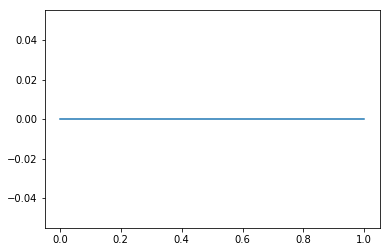

In [17]:
dat.plot_all()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

In [18]:
dat.data[dat.object_names[0]]

mjd,flux,flux_error,filter,zp,zpsys
float32,float32,float32,str5,float64,str2
0.0,-48.6896,29.235,lssty,27.5,ab
2.0056,-3.94192,3.08151,lsstr,27.5,ab
3.0035,-0.284547,5.14292,lssti,27.5,ab
3.9708,4.57969,3.3554,lsstr,27.5,ab
4.9862,-3.84353,6.59962,lssti,27.5,ab
7.9804,-2.07115,4.94633,lssti,27.5,ab
8.9694,9.54924,3.80211,lsstr,27.5,ab
9.9646,0.6082,4.37336,lsstr,27.5,ab
11.989,7.84257,4.38428,lssti,27.5,ab


## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

In [19]:
read_from_file=False #We can use this flag to quickly rerun from saved features

out_features_dat=os.path.join(example_data, out_features,'features') #Where we save the extracted features to
subprocess.call(['mkdir', '-p',out_features_dat])

run_name=os.path.join(example_data, out_features,'%s_all' %dataset)
print(run_name)

/Users/tallamjr/PhD/project/snmachine/snmachine/example_data/output_lsst_wfd_no_z/features/lsst_wfd_all


t-SNE plots: 
These are useful visualisation plots which embed high dimensional features into a lower dimensional space to indicate how well the features separate between classes (see https://lvdmaaten.github.io/tsne/)

### Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [20]:
waveFeats=snfeatures.WaveletFeatures()

In [21]:
%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
else:
    wave_features=waveFeats.extract_features(dat,nprocesses=6,output_root=out_int,save_output='all')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean

Performing Gaussian process regression
24272867
17603592
12926636
91722
6918753
26117041


KeyboardInterrupt: 

In [22]:
dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)

NameError: name 'wave_features' is not defined

Process ForkPoolWorker-9:
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/snmachine/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/envs/snmachine/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/envs/snmachine/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/anaconda3/envs/snmachine/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
_pickle.UnpicklingError: invalid load key, ';'.


In [ ]:
dat.plot_all()

In [ ]:
plt.figure()
tsne_plot.plot(wave_features,join(wave_features,types)['Type'])

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [ ]:
nproc=4

In [ ]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

### Wavelet features

In [ ]:
plt.figure()
clss=snclassifier.run_pipeline(wave_features,types,output_name=os.path.join(out_class,'wavelets'),
                          classifiers=['random_forest'], nprocesses=nproc)